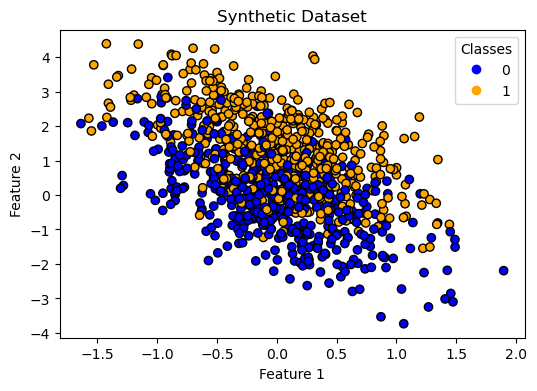

In [82]:
# Create 2 slightly overlapping blobs and plot them
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from typing import *

from sklearn.datasets import make_blobs

centers = [[0, 0], [1, 1]]
X, y = make_blobs(n_samples=1_000, centers=centers, random_state=0)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

fig, ax = plt.subplots(figsize=(6, 4))

cmap = ListedColormap(["blue", "orange"])
scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolor="black")

ax.set(title="Synthetic Dataset", xlabel="Feature 1", ylabel="Feature 2")
_ = ax.legend(*scatter.legend_elements(), title="Classes")

In [26]:
# Fit a logistic regression
from sklearn.linear_model import LogisticRegression

logistic_regression_multinomial = LogisticRegression().fit(X, y)

accuracy_multinomial = logistic_regression_multinomial.score(X, y)

In [ ]:
# Outlier generation function using the skew-based method

# (!) As a design choice, calculate variance vector over all datapoints, not just within the class
def unit_scale(v):
    return v/np.sum(v)


# # Generate an offset using the skew-based method and a certain level
# def generate_offset(X: np.array, alpha: float):
#     stdevs = np.std(X, axis=0)
#     v = unit_scale(stdevs)          # wait.. why do we normalize this? consider not normalizing this

#     d = X.shape[1]

#     zero_mean = np.zeros((d,))
#     identity_covariance = np.identity(d)
#     rng = np.random.default_rng()

#     rands = rng.multivariate_normal(mean = zero_mean, cov = identity_covariance)
#     noise = unit_scale(rands)       # scaling means that certain amount of change always, just in which directions -> ensures actual outliers

#     # print(rands)
#     return alpha * np.multiply(v, noise)

In [ ]:
# Generate n_art outliers with the given alpha based on the given dataset
def generate_outliers(X: np.array, y: np.array, n_art: int, alpha: float) -> Tuple[np.array, np.array]:
    # Get the shape
    n, d = X.shape

    # Generate a d-dimensional vecotr of normally distributed random variables that are scaled so that entries sum to 1
    def generate_noise():
        zero_mean = np.zeros((d,))
        identity_covariance = np.identity(d)
        rng = np.random.default_rng()
        rands = rng.multivariate_normal(mean = zero_mean, cov = identity_covariance)
        noise = unit_scale(rands)   
        return noise

    # Compute the v vector for the given X data. 
    # (!) As a design choice, calculate variance vector over all datapoints, not just within the class
    stdevs = np.std(X, axis=0)
    v = unit_scale(stdevs)          # wait.. why do we normalize this? consider not normalizing this

    # Initialize the generated outlier arrays 
    X_art = np.empty((n_art, d))
    y_art = np.empty((n_art,))

    for i in range(n_art):
        # Sample a random index j from the dataset X, y (i.e. random instance)
        j = np.random.randint(0, X.shape[0])

        # Set the label to be the same
        y_art[i] = y[j]

        # Set the features to be those of an offset with the genreated offset
        noise = generate_noise()
        offset = alpha * np.multiply(v, noise)
        X_art[i] = X[j] + offset

    return X_art, y_art

In [102]:
X_art, y_art = generate_outliers(X, y, n_art = 100, alpha = 1)

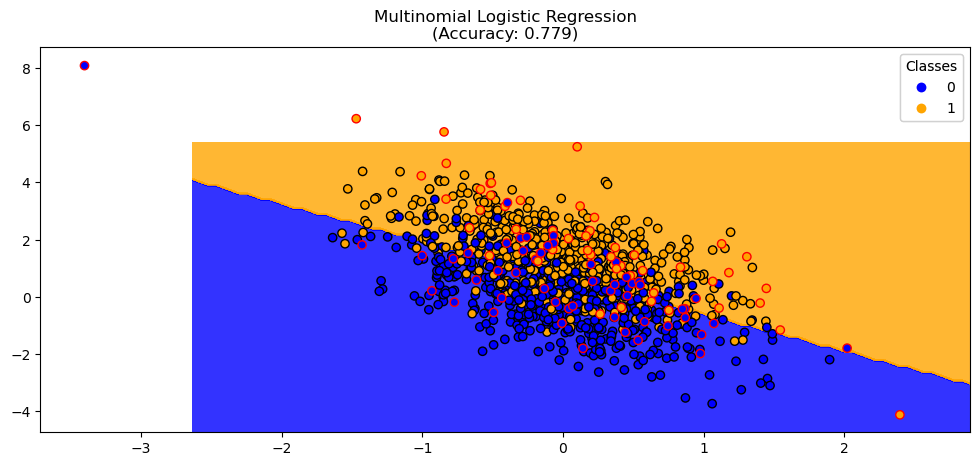

In [103]:
from sklearn.inspection import DecisionBoundaryDisplay

fig, ax1 = plt.subplots(1, 1, figsize=(12, 5), sharex=True, sharey=True)

for model, title, ax in [
    (
        logistic_regression_multinomial,
        f"Multinomial Logistic Regression\n(Accuracy: {accuracy_multinomial:.3f})",
        ax1,
    )
]:
    DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        ax=ax,
        response_method="predict",
        alpha=0.8,
        cmap=cmap
    )
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolor="black")

    ax1.scatter(X_art[:, 0], X_art[:, 1], c=y_art, cmap=cmap, edgecolor="red")      # Plot the artificial points

    legend = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend)
    ax.set_title(title)